# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.
* $A^c = P^T A Q$ is constructed locally and tiled, so that there is no fill-in due to $P$ in $P^T A P$.

In [333]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [334]:
def plot_svd_coarsening_accuracy(level, num_sweeps: int, aggregate_size: int, num_components):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
     
    # Create relaxed TVs.
    x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4)
    b = np.zeros_like(x_random)
    x = hm.solve.run.run_iterative_method(
       level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    
    #x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4 * aggregate_size)
    #b = np.zeros_like(x_random)
    #x = hm.solve.run.run_iterative_method(
    #    level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    #start, end = 0, aggregate_size
    #x_aggregate_t = x[start:end].transpose()
    #print(x_aggregate_t.shape)
    #r, s = hm.repetitive.coarsening_repetitive.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()
    display(pd.DataFrame(r))

    # Relaxed vectors.
    ax = axs[0]
    for i in range(min(3, x.shape[1])):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);

    # TODO: replace by local mock cycle rate.
    nu_values = np.arange(1, 12)
    R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
    print("nu", "{:3d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
    #hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv {}".format(np.array2string(mock_conv, precision=3)))

#         # Generate coarse variables (R) on the non-repetitive domain.
#         r, aggregates, nc, energy_error = hm.repetitive.coarsening_repetitive.create_coarsening_domain(
#             x, threshold=threshold, fixed_aggregate_size=aggregate_size)
#         _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
#         _LOGGER.info("nc  {}".format(nc))
#         _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [335]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.49071886103381146


## Level 0->1 Coarsening

In [336]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.272e+00                    4.470e-01    2.847
INFO     1     7.091e-01 (0.558) [0.558]    3.506e-01    2.026 (0.712)
INFO     2     4.157e-01 (0.586) [0.572]    3.054e-01    1.366 (0.674)
INFO     3     2.624e-01 (0.631) [0.591]    2.821e-01    0.934 (0.684)
INFO     4     1.810e-01 (0.690) [0.614]    2.683e-01    0.678 (0.725)
INFO     5     1.369e-01 (0.757) [0.641]    2.590e-01    0.531 (0.784)
INFO     6     1.115e-01 (0.815) [0.667]    2.520e-01    0.444 (0.837)
INFO     7     9.562e-02 (0.857) [0.691]    2.464e-01    0.389 (0.877)
INFO     8     8.500e-02 (0.888) [0.713]    2.416e-01    0.352 (0.906)
INFO     9     7.725e-02 (0.908) [0.733]    2.374e-01    0.326 (0.924)
INFO     10    7.134e-02 (0.923) [0.750]    2.337e-01    0.305 (0.937)
INFO     11    6.668e-02 (0.934) [0.765]    2.304e-01    0.289 (0.947)
INFO     12    6.288e-02 (0.942) [0.778]    2.273e-01    0.276 (0.955)
INFO 

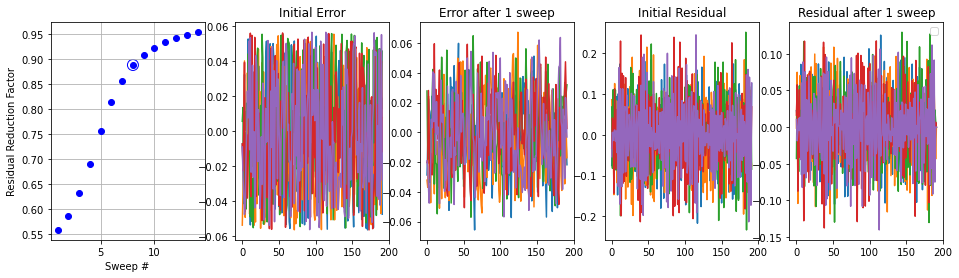

In [337]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [338]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.120


### Coarsening: Fixed (4/2)

In [339]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3
0,0.50,0.59,0.53,0.35
1,0.64,0.16,-0.33,-0.68


nu 100 s [1.    0.461 0.043 0.006] Energy error [0.42  0.04  0.005 0.   ]
INFO     Mock cycle conv [0.606 0.328 0.195 0.143 0.141 0.123 0.082 0.061 0.059 0.053 0.048]


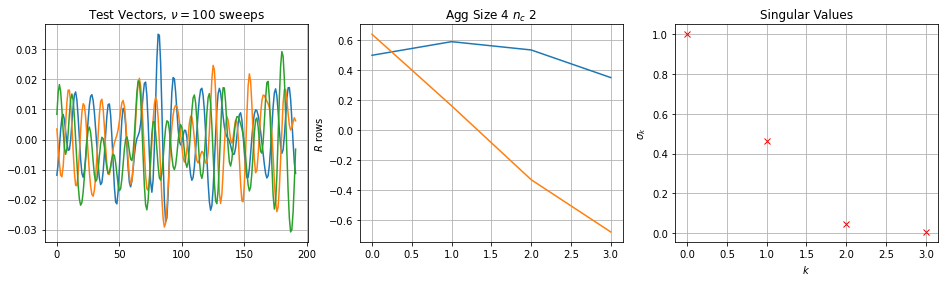

In [340]:
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.30,-0.48,-0.58,-0.58,0.00,0.00,0.00,0.00,0.00,0.00
1,0.71,0.37,-0.10,-0.58,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.30,-0.48,-0.58,-0.58,0.00,0.00
3,0.00,0.00,0.00,0.00,0.71,0.37,-0.10,-0.58,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.30,-0.48


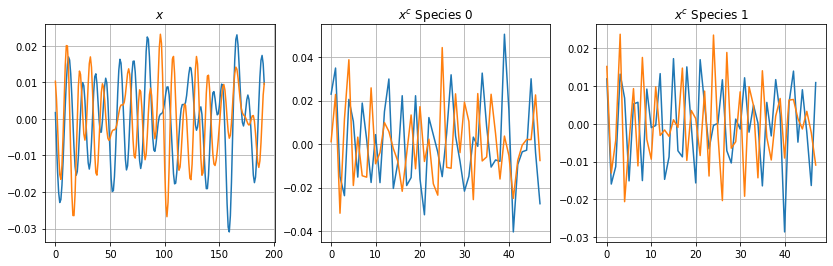

In [341]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [342]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.492 0.251 0.148 0.136 0.145 0.101 0.085 0.073]


### Interpolation $P = R^T$

In [343]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.87


### Interpolation by LS Fitting

In [344]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

INFO     X sample matrix  (72, 4)
INFO     X sample matrix  (72, 4)
INFO     X sample matrix  (72, 4)
INFO     X sample matrix  (72, 4)
INFO     X sample matrix  (72, 4)
INFO     X sample matrix  (72, 4)


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.49,0.25,0.15,0.14,0.14,0.10,0.08,0.07
P=R^T,nan,nan,nan,nan,nan,0.56,0.35,0.49,0.48,0.45,0.44,0.43,0.42
P^T A P caliber 2,0.00,2.00,384.00,1.20,0.00,0.52,0.35,0.43,0.46,0.39,0.39,0.39,0.38
P^T A P caliber 3,0.00,3.00,576.00,1.40,0.00,0.61,0.33,0.27,0.33,0.27,0.24,0.25,0.24
P^T A P caliber 4,0.00,4.00,768.00,2.00,0.00,0.60,0.33,0.21,0.15,0.15,0.14,0.10,0.07
R A P caliber 2,1.00,2.00,384.00,1.20,0.04,0.51,0.37,0.44,0.47,0.40,0.40,0.40,0.39
R A P caliber 3,1.00,3.00,576.00,1.20,0.04,0.92,0.34,0.32,0.37,0.32,0.31,0.32,0.31
R A P caliber 4,1.00,4.00,768.00,1.20,0.01,0.69,0.38,0.30,0.22,0.17,0.14,0.10,0.08


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [345]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.29,0.73
1,-0.49,0.36
2,-0.59,-0.12
3,-0.57,-0.56


A^1


,0,1,2,3,4,5
0,-0.28,-0.26,0.18,-0.50,0.18,0.19
1,-0.26,-1.43,0.19,-0.52,-0.50,-0.52


caliber 3 P


,0,1,2,3
0,-0.31,0.65,0.00,-0.06
1,-0.47,0.42,0.00,0.05
2,-0.59,-0.17,0.04,0.00
3,-0.57,-0.50,-0.05,0.00


A^1


,0,1,2,3,4,5,6,7
0,-0.19,-0.22,0.16,-0.40,0.00,0.00,0.16,0.15
1,-0.22,-1.17,0.15,-0.41,0.00,0.00,-0.40,-0.41


caliber 4 P


,0,1,2,3,4,5
0,-0.28,0.50,0.00,0.00,-0.15,-0.15
1,-0.49,0.52,0.00,0.00,0.10,0.10
2,-0.67,-0.29,0.06,-0.14,0.00,0.00
3,-0.47,-0.36,-0.07,0.18,0.00,0.00


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.14,-0.18,0.14,-0.33,0.01,-0.02,0.01,0.01,0.14,0.14
1,-0.18,-0.96,0.14,-0.33,0.01,-0.02,-0.02,-0.02,-0.33,-0.33


R*A*P
caliber 2 P


,0,1
0,-0.29,0.73
1,-0.49,0.36
2,-0.59,-0.12
3,-0.57,-0.56


A^1


,0,1,2,3,4,5
0,-0.29,-0.26,0.18,-0.51,0.19,0.20
1,-0.28,-1.43,0.20,-0.55,-0.49,-0.51


caliber 3 P


,0,1,2,3
0,-0.31,0.65,0.00,-0.06
1,-0.47,0.42,0.00,0.05
2,-0.59,-0.17,0.04,0.00
3,-0.57,-0.50,-0.05,0.00


A^1


,0,1,2,3,4,5
0,-0.22,-0.23,0.17,-0.45,0.18,0.17
1,-0.25,-1.27,0.16,-0.48,-0.42,-0.45


caliber 4 P


,0,1,2,3,4,5
0,-0.28,0.50,0.00,0.00,-0.15,-0.15
1,-0.49,0.52,0.00,0.00,0.10,0.10
2,-0.67,-0.29,0.06,-0.14,0.00,0.00
3,-0.47,-0.36,-0.07,0.18,0.00,0.00


A^1


,0,1,2,3,4,5
0,-0.09,-0.12,0.14,-0.22,0.14,0.10
1,-0.12,-0.62,0.11,-0.13,-0.23,-0.14


In [346]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 2.422e+01 RER 2.95702
INFO         1 |r| 5.028e+00 (0.20759) RER 0.30104 (0.10181) 16.702
INFO         2 |r| 1.300e+00 (0.25845) RER 0.08764 (0.29111) 14.828
INFO         3 |r| 3.109e-01 (0.23922) RER 0.02188 (0.24971) 14.205
INFO         4 |r| 6.721e-02 (0.21619) RER 0.00469 (0.21419) 14.338
INFO         5 |r| 1.588e-02 (0.23622) RER 0.00111 (0.23642) 14.326
INFO         6 |r| 4.141e-03 (0.26084) RER 0.00029 (0.26091) 14.323
INFO         7 |r| 1.162e-03 (0.28064) RER 0.00008 (0.28061) 14.324
INFO         8 |r| 3.137e-04 (0.26995) RER 0.00002 (0.26995) 14.324
INFO         9 |r| 8.020e-05 (0.25564) RER 0.00001 (0.25564) 14.324
INFO        10 |r| 2.393e-05 (0.29834) RER 0.00000 (0.29834) 14.324
INFO        11 |r| 6.572e-06 (0.27467) RER 0.00000 (0.27467) 14.324
INFO        12 |r| 1.886e-06 (0.28690) RER 0.00000 (0.28690) 14.324
INFO        13 |r| 5.439e-07 (0.28843) RER 0.00000 (0.28843) 14.324
INFO        14 |r| 1.525e-07 (0.28036) RER 0.00000 (0.28036) 14.324
INFO   

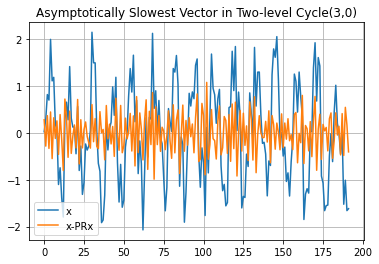

In [347]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].p.dot(m0[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [348]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [ 0.     0.     0.031  0.031 -0.033 -0.033  0.06   0.06  -0.068 -0.068  0.087  0.087]
1 lam [-0.    -0.     0.031  0.031 -0.034 -0.034  0.06   0.06  -0.069 -0.069  0.087  0.087]


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [349]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [350]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.457e-01                    4.469e-01    0.550
INFO     1     7.615e-02 (0.312) [0.312]    2.770e-01    0.276 (0.503)
INFO     2     4.930e-02 (0.648) [0.449]    2.237e-01    0.221 (0.803)
INFO     3     3.168e-02 (0.643) [0.506]    1.962e-01    0.162 (0.734)
INFO     4     2.373e-02 (0.748) [0.558]    1.805e-01    0.132 (0.813)
INFO     5     1.954e-02 (0.823) [0.603]    1.694e-01    0.115 (0.877)
INFO     6     1.671e-02 (0.855) [0.639]    1.610e-01    0.104 (0.900)
INFO     7     1.467e-02 (0.878) [0.669]    1.543e-01    0.095 (0.916)
INFO     8     1.312e-02 (0.895) [0.694]    1.487e-01    0.088 (0.928)
INFO     9     1.190e-02 (0.907) [0.715]    1.440e-01    0.083 (0.937)
INFO     10    1.090e-02 (0.917) [0.733]    1.399e-01    0.078 (0.944)
INFO     11    1.007e-02 (0.924) [0.748]    1.363e-01    0.074 (0.949)
INFO     12    9.373e-03 (0.931) [0.762]    1.330e-01    0.070 (0.953)
INFO 

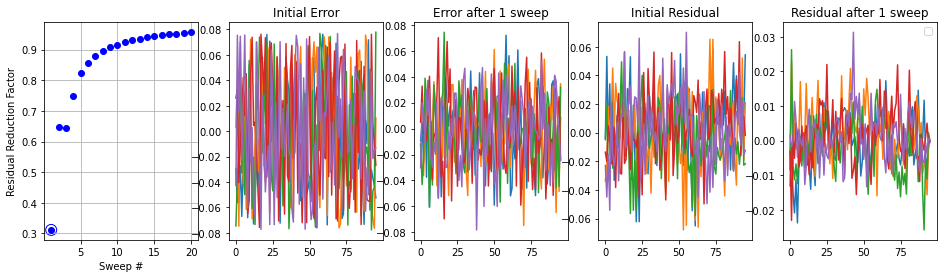

In [352]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20, x0=x0)
num_sweeps = method_info["Kaczmarz"][1]

,0,1,2,3
0,-0.60,-0.38,0.25,0.66
1,-0.05,0.63,0.78,0.03


nu 100 s [1.    0.76  0.475 0.396] Energy error [0.7   0.442 0.283 0.   ]
INFO     Mock cycle conv [0.511 0.448 0.392 0.375 0.347 0.325 0.292 0.264 0.25  0.221 0.199]


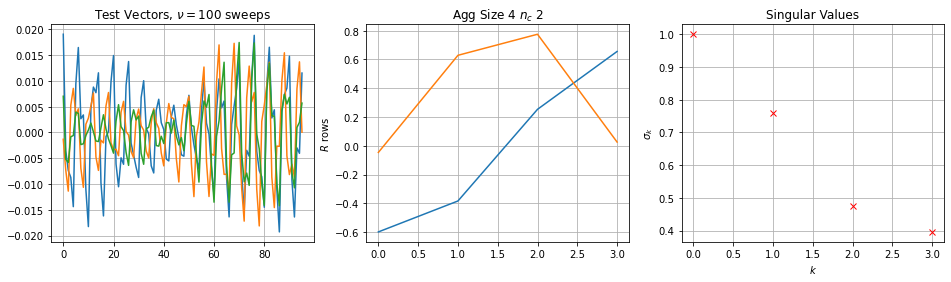

In [353]:
# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [354]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.14,0.10,-0.09,-0.12,0.14,-0.22
1,-0.23,-0.14,-0.12,-0.62,0.11,-0.13


In [355]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.016


In [356]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.14,0.10,-0.09,-0.12,0.14,-0.22
1,-0.23,-0.14,-0.12,-0.62,0.11,-0.13


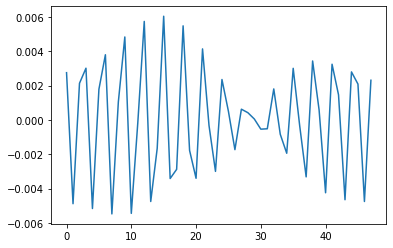

In [357]:
plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [358]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [359]:
 np.correlate(x[:, 0], x[:, 0], mode='full')

array([ 0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.001, -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.001, -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.001, -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.001, -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,
        0.   , -0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.001, -0.   ,  0.   ,  0.001,  0.001, -0.   , -0.001, -0.001,  0.   ,  0.001,  0.001,  0.   , -0.001, -0.001, -0.   ,  0.001,  0.001,  0.   , -0.001, -0.001, -0.001,  0.001,  0.002,  0.001, -0.001, -0.001, -0.001,  0.   ,  0.001,  0.001, -0.   , -0.001, -0.001,  0.   ,  0.001,  0.001,  0.   , -0.001, -0.001, -0.   ,  0.001,  0.001,  0.   , -0.   , -0.001, -0.   ,  0.   ,  0.   ,  0.   ,
       -0.

[1.    0.916 0.333 0.165]
(48, 96)


,0,1,2,3,4,5,6,7,8,9
0,-0.59,-0.22,0.52,0.57,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.03,0.65,0.65,-0.38,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.59,-0.22,0.52,0.57,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.03,0.65,0.65,-0.38,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.59,-0.22


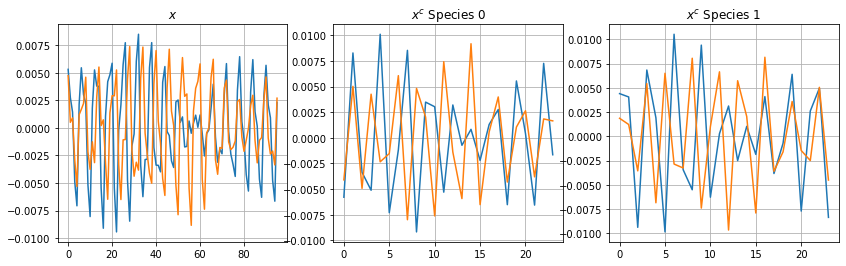

In [360]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

In [361]:
# a = level.a
# display(pd.DataFrame(a.todense()))

### Mock Cycle Rate

In [362]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.524 0.525 0.48  0.456 0.418 0.394 0.357 0.343 0.319 0.284 0.276]


In [363]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [364]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.59


### Interpolation by LS Fitting

In [365]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        #print(a.shape, R.shape, level.location.shape)
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

INFO     X sample matrix  (70, 4)
INFO     X sample matrix  (70, 4)
INFO     X sample matrix  (70, 4)
INFO     X sample matrix  (70, 4)
INFO     X sample matrix  (70, 4)
INFO     X sample matrix  (70, 4)


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.52,0.53,0.48,0.46,0.42,0.39,0.36,0.34,0.32,0.28,0.28
P=R^T,nan,nan,nan,nan,nan,9.29,9.47,17.38,22.83,27.09,30.12,32.18,33.47,34.25,34.64,34.64
P^T A P caliber 2,0.00,2.00,192.00,1.00,0.00,36.03,19.27,19.25,20.91,20.65,19.98,18.95,17.48,15.82,14.17,12.62
P^T A P caliber 3,0.00,3.00,288.00,1.17,0.00,0.67,0.52,0.20,0.09,0.07,0.05,0.04,0.04,0.05,0.05,0.06
P^T A P caliber 4,0.00,4.00,384.00,1.67,0.00,0.25,0.27,0.13,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01
R A P caliber 2,1.00,2.00,192.00,1.00,0.11,1.91,1.78,1.72,1.59,1.56,1.44,1.38,1.25,1.20,1.09,1.10
R A P caliber 3,1.00,3.00,288.00,1.00,0.07,3.02,2.68,2.55,2.33,2.16,1.98,1.83,1.76,1.61,1.46,1.37
R A P caliber 4,1.00,4.00,384.00,1.00,0.02,0.48,0.51,0.47,0.44,0.41,0.38,0.36,0.34,0.32,0.31,0.30


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 5.418e+00 RER 0.91925
INFO         1 |r| 1.264e+00 (0.23332) RER 0.20319 (0.22104) 6.221
INFO         2 |r| 3.081e-01 (0.24372) RER 0.05236 (0.25766) 5.884
INFO         3 |r| 8.201e-02 (0.26620) RER 0.01393 (0.26609) 5.887
INFO         4 |r| 2.214e-02 (0.27002) RER 0.00376 (0.27024) 5.882
INFO         5 |r| 6.012e-03 (0.27148) RER 0.00102 (0.27149) 5.882
INFO         6 |r| 1.636e-03 (0.27207) RER 0.00028 (0.27207) 5.882
INFO         7 |r| 4.454e-04 (0.27232) RER 0.00008 (0.27232) 5.882
INFO         8 |r| 1.214e-04 (0.27246) RER 0.00002 (0.27246) 5.882
INFO         9 |r| 3.308e-05 (0.27255) RER 0.00001 (0.27255) 5.882
INFO        10 |r| 9.017e-06 (0.27260) RER 0.00000 (0.27260) 5.882
INFO        11 |r| 2.458e-06 (0.27264) RER 0.00000 (0.27264) 5.882
INFO        12 |r| 6.703e-07 (0.27268) RER 0.00000 (0.27268) 5.882
INFO        13 |r| 1.828e-07 (0.27272) RER 0.00000 (0.27272) 5.882
INFO        14 |r| 4.986e-08 (0.27276) RER 0.00000 (0.27276) 5.882
INFO        15 |r| 1.

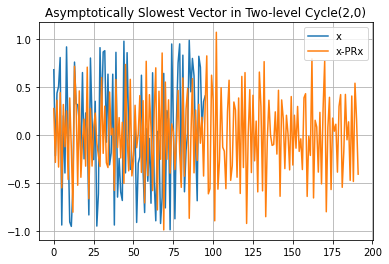

In [366]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
p = p_experiment[False][-1]  # P^T*A*P P high order
use_r_as_restriction = False

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [367]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.    -0.     0.031  0.031 -0.034 -0.034  0.06   0.06  -0.069 -0.069  0.087  0.087]
1 lam [-0.    -0.     0.013  0.018  0.018  0.032  0.032  0.033  0.033 -0.039 -0.039  0.053]


## 3-Level Method

In [368]:
m0.add(m1[1])

INFO         0 |r| 2.816e+01 RER 3.43963
INFO         1 |r| 1.924e+00 (0.06832) RER 0.06335 (0.01842) 30.365
INFO         2 |r| 2.818e-01 (0.14647) RER 0.00938 (0.14810) 30.033
INFO         3 |r| 3.807e-02 (0.13513) RER 0.00126 (0.13467) 30.135
INFO         4 |r| 5.880e-03 (0.15443) RER 0.00020 (0.15436) 30.147
INFO         5 |r| 9.476e-04 (0.16117) RER 0.00003 (0.16118) 30.146
INFO         6 |r| 1.530e-04 (0.16143) RER 0.00001 (0.16143) 30.146
INFO         7 |r| 2.556e-05 (0.16711) RER 0.00000 (0.16711) 30.146
INFO         8 |r| 4.192e-06 (0.16397) RER 0.00000 (0.16397) 30.146
INFO         9 |r| 6.989e-07 (0.16674) RER 0.00000 (0.16674) 30.146
INFO        10 |r| 1.184e-07 (0.16947) RER 0.00000 (0.16947) 30.146
INFO        11 |r| 1.990e-08 (0.16797) RER 0.00000 (0.16797) 30.146
INFO        12 |r| 3.337e-09 (0.16771) RER 0.00000 (0.16771) 30.146
INFO        13 |r| 5.644e-10 (0.16916) RER 0.00000 (0.16916) 30.146
INFO        14 |r| 9.616e-11 (0.17037) RER 0.00000 (0.17037) 30.146


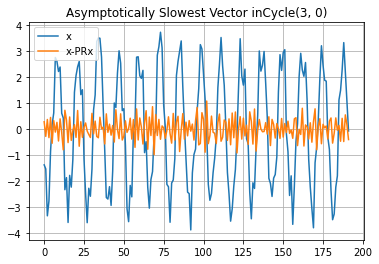

In [369]:
nu_pre = 3
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector inCycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [370]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [ 0.     0.     0.031  0.031 -0.033 -0.033  0.06   0.06  -0.068 -0.068  0.087  0.087]
1 lam [-0.    -0.     0.031  0.031 -0.034 -0.034  0.06   0.06  -0.069 -0.069  0.087  0.087]
2 lam [-0.    -0.     0.013  0.018  0.018  0.032  0.032  0.033  0.033 -0.039 -0.039  0.053]
